In [7]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, BatchNormalization, Dropout, Bidirectional
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pandas as pd
from keras import optimizers
import math

In [2]:
df = pd.read_csv('./Glucose_Train_Set.csv')

val_df = pd.read_csv('./Glucose_Validation_Set_Complete.csv')[['SID','Day','DailyTI_Index','Value']]
val_missing = pd.read_csv('./Glucose_Validation_Set.csv')[['SID','Day','DailyTI_Index','Value']]

In [3]:
missing_data = pd.merge(val_df, val_missing, on = ['SID','Day','DailyTI_Index'], how = 'left')
missing_data.columns = ['SID','Day','DailyTI_Index','Value_complete', 'Value_missing']

In [4]:
train_data = df.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value'].apply(list).reset_index()
validation_missing = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_missing'].apply(list).reset_index()
validation_complete = missing_data.sort_values(by=['DailyTI_Index']).groupby(['SID', 'Day'])['Value_complete'].apply(list).reset_index()


In [5]:
y_val = np.array(validation_missing['Value_missing'].to_list())

In [6]:
X_train = np.array(train_data['Value'].to_list())

In [10]:
# Normalize the data
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Reshaping X_train for the LSTM model, LSTM expects input to be in [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))

# Define a Seq2Seq LSTM model best was 50 and 50
model = Sequential([
    Bidirectional(LSTM(50, activation='sigmoid', input_shape=(288, 1), return_sequences=False)), # set to false for seq2seq
    RepeatVector(288),  # Determines the length of the output sequence
    Bidirectional(LSTM(50, activation='sigmoid', return_sequences=True)),
    TimeDistributed(Dense(1))
])

optimizer = optimizers.Adam(learning_rate = 0.001, clipvalue=0.5) # for seq2seq clipvalue=0.5
model.compile(optimizer=optimizer, loss='mse')

# Train the model
model.fit(X_train_reshaped, X_train_reshaped, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
1107/1107 [==============================] - 494s 445ms/step - loss: 0.7087
Epoch 2/20
1107/1107 [==============================] - 454s 411ms/step - loss: 0.5442
Epoch 3/20
1107/1107 [==============================] - 449s 406ms/step - loss: 0.4797
Epoch 4/20
1107/1107 [==============================] - 832s 752ms/step - loss: 0.4170
Epoch 5/20
1107/1107 [==============================] - 425s 384ms/step - loss: 0.3761
Epoch 6/20
1107/1107 [==============================] - 1410s 1s/step - loss: 0.3477
Epoch 7/20
1107/1107 [==============================] - 503s 454ms/step - loss: 0.3180
Epoch 8/20
1107/1107 [==============================] - 470s 425ms/step - loss: 0.2746
Epoch 9/20
1107/1107 [==============================] - 478s 432ms/step - loss: 0.2362
Epoch 10/20
1107/1107 [==============================] - 480s 434ms/step - loss: 0.2175
Epoch 11/20
1107/1107 [==============================] - 494s 447ms/step - loss: 0.2018
Epoch 12/20
1107/1107 [====================

In [11]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_3 (Bidirectio  (None, 100)              20800     
 nal)                                                            
                                                                 
 repeat_vector_1 (RepeatVect  (None, 288, 100)         0         
 or)                                                             
                                                                 
 bidirectional_4 (Bidirectio  (None, 288, 100)         60400     
 nal)                                                            
                                                                 
 time_distributed_2 (TimeDis  (None, 288, 1)           101       
 tributed)                                                       
                                                                 
Total params: 81,301
Trainable params: 81,301
Non-trai

In [12]:
# Prepare the test sequence
test_sequences = y_val
# Handle NaNs for normalization (simple imputation, consider a better method for your use case)
test_sequences_imputed = np.array([np.where(np.isnan(seq), np.nanmean(seq), seq) for seq in test_sequences])

# Standardize the test sequences
test_sequences_scaled = scaler.transform(test_sequences_imputed)

# Reshape for the model
test_sequences_scaled_reshaped = test_sequences_scaled.reshape((test_sequences_scaled.shape[0], 288, 1))

# Predicting the sequences
predicted_sequences_scaled = model.predict(test_sequences_scaled_reshaped)

# Inverse transform to original scale
predicted_sequences = scaler.inverse_transform(predicted_sequences_scaled.reshape(test_sequences_scaled.shape[0], 288))


317/317 [==============================] - 16s 49ms/step


In [13]:
predictions = []

# Iterate through each row in the array and append it as a list to data_for_df
for row in predicted_sequences:
    predictions.append(row)  # Each row becomes a list that is then wrapped in another list to represent a single cell in the DataFrame


In [94]:
validation_missing['Value_prediction_seq'] = predictions

In [95]:
preds_vs_true = pd.merge(validation_missing, validation_complete)

In [99]:
def find_nan_indices(lst):
    """
    Returns a list of indices where the item in the list is NaN.
    
    :param lst: List to check for NaN values.
    :return: List of indices with NaN values.
    """
    return [i for i, x in enumerate(lst) if isinstance(x, float) and np.isnan(x)]

# Now, apply the function to the 'Value_missing' column
preds_vs_true['Missing_Indexes'] = preds_vs_true['Value_missing'].apply(find_nan_indices)

In [108]:
RMSEs =[]
missing_count = []
predicted_values = []
true_values = []

for j in range(len(preds_vs_true)):
    check_list = []
    count = 0
    pred_vals = []
    true_val = []
    for i in find_nan_indices(preds_vs_true['Value_missing'][j]):
        check_list.append((preds_vs_true['Value_complete'][j][i] - preds_vs_true['Value_prediction_seq'][j][i])**2)
        count += 1
        pred_vals.append(preds_vs_true['Value_prediction_seq'][j][i])
        true_val.append(preds_vs_true['Value_complete'][j][i])
    
    RMSEs.append(np.mean(check_list)**(1/2))
    missing_count.append(count)
    predicted_values.append(pred_vals)
    true_values.append(true_val)

In [109]:
preds_vs_true['Avg RMSE'] = RMSEs
preds_vs_true['missing_count'] = missing_count
preds_vs_true['Predicted_Values'] = predicted_values
preds_vs_true['True_Values'] = true_values

In [110]:
preds_vs_true['offset_start'] = preds_vs_true['Missing_Indexes'].apply(np.array).apply(min)-1
preds_vs_true['offset_value'] = preds_vs_true.apply(lambda row: row['Value_missing'][row['offset_start']], axis=1) - \
                                    preds_vs_true.apply(lambda row: row['Value_prediction_seq'][row['offset_start']], axis=1)



In [113]:
# Add the single float to each element of the lists
preds_vs_true['Offset_Predicted_Values'] = preds_vs_true.apply(lambda row: [x + row['offset_value'] for x in row['Predicted_Values']], axis=1)

In [120]:
# Display the DataFrame
preds_vs_true['Offset_Sq_Error'] = preds_vs_true.apply(lambda row: [(a - b)**2 for a, b in zip(row['True_Values'], row['Offset_Predicted_Values'])], axis=1)

In [128]:
preds_vs_true['Offset_RMSE']= preds_vs_true['Offset_Sq_Error'].apply(np.array).apply(np.mean).apply(math.sqrt)

In [130]:
preds_vs_true.groupby('missing_count')['Offset_RMSE'].mean()

missing_count
4      9.032488
5     10.797466
6     12.394360
7     13.927263
8     14.743390
9     14.940102
10    17.446390
11    18.023127
12    19.418940
24    28.677503
48    42.592675
96    57.884190
Name: Offset_RMSE, dtype: float64

In [36]:
preds_vs_true.groupby('missing_count')['Avg RMSE'].mean()

missing_count
4     22.446452
5     24.017871
6     24.960449
7     25.680269
8     25.371429
9     26.290859
10    27.493724
11    28.130844
12    28.932305
24    37.512862
48    47.692698
96    57.624807
Name: Avg RMSE, dtype: float64

In [154]:
preds_vs_true

,SID,Day,Value_missing,Value_prediction,Value_prediction_seq,Value_complete,Missing_Indexes,Avg RMSE,missing_count,Predicted_Values,offset_start,offset_value,Offset_Predicted_Values,True_Values,Offset_Sq_Error,Offset_RMSE
0,CITY-1,2,"[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...","[288.2032, 300.55865, 308.7281, 314.70218, 318...","[288.2032, 300.55865, 308.7281, 314.70218, 318...","[306.0, 301.0, 301.0, 301.0, 300.0, 306.0, 312...","[30, 31, 32, 33]",6.548246,4,"[266.5671, 264.07492, 261.60632, 259.1759]",29,-3.029236,"[263.5378723144531, 261.0456848144531, 258.577...","[268.0, 271.0, 255.0, 268.0]","[19.91058348212391, 99.08839081320912, 12.7955...",8.250697
1,CITY-1,11,"[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...","[251.57312, 252.9743, 252.78651, 253.11372, 25...","[251.57312, 252.9743, 252.78651, 253.11372, 25...","[248.0, 251.0, 251.0, 254.0, 257.0, 262.0, 268...","[77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 8...",177.575653,96,"[284.52856, 280.2009, 275.7097, 271.06567, 266...",76,78.297913,"[362.82647705078125, 358.4988098144531, 354.00...","[370.0, 371.0, 374.0, 376.0, 379.0, 380.0, 353...","[51.45943150296807, 156.2797560552135, 399.696...",105.652913
2,CITY-1,207,"[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...","[194.76012, 206.34258, 212.96732, 217.12534, 2...","[194.76012, 206.34258, 212.96732, 217.12534, 2...","[206.0, 204.0, 202.0, 202.0, 204.0, 208.0, 211...","[266, 267, 268, 269, 270, 271, 272]",37.216855,7,"[143.8032, 143.24698, 142.78838, 142.4038, 142...",265,37.562134,"[181.36534118652344, 180.80911254882812, 180.3...","[185.0, 186.0, 184.0, 178.0, 175.0, 174.0, 175.0]","[13.210744690382853, 26.945312530733645, 13.31...",4.299827
3,CITY-1,282,"[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...","[239.39206, 254.29585, 262.61258, 268.08087, 2...","[239.39206, 254.29585, 262.61258, 268.08087, 2...","[266.0, 270.0, 265.0, 261.0, 258.0, 257.0, 253...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",110.669980,48,"[161.56691, 162.92892, 164.33928, 165.82591, 1...",107,-69.236221,"[92.3306884765625, 93.69270324707031, 95.10305...","[88.0, 86.0, 83.0, 81.0, 80.0, 82.0, 85.0, 87....","[18.754862681031227, 59.17768324748613, 146.48...",43.849430
4,CITY-1,283,"[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...","[194.71466, 193.90762, 191.21535, 188.86458, 1...","[194.71466, 193.90762, 191.21535, 188.86458, 1...","[234.0, 223.0, 214.0, 206.0, 195.0, 180.0, 167...","[108, 109, 110, 111, 112, 113, 114, 115, 116, ...",6.463759,24,"[203.50978, 204.51129, 205.46542, 206.42049, 2...",107,-0.433762,"[203.07601928710938, 204.07752990722656, 205.0...","[204.0, 203.0, 206.0, 206.0, 204.0, 205.0, 208...","[0.8537403577938676, 1.1610707009676844, 0.937...",6.681949
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10113,WISDM-98,174,"[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....","[111.292046, 102.61971, 95.85383, 92.09809, 90...","[111.292046, 102.61971, 95.85383, 92.09809, 90...","[91.0, 92.0, 92.0, 93.0, 94.0, 95.0, 94.0, 94....","[26, 27, 28, 29, 30, 31, 32, 33, 34]",18.354280,9,"[101.39682, 101.88097, 102.30979, 102.71335, 1...",25,13.119682,"[114.5165023803711, 115.00064849853516, 115.42...","[118.0, 120.0, 122.0, 123.0, 123.0, 123.0, 122...","[12.134755665960256, 24.993515435198788, 43.17...",5.405681
10114,WISDM-98,183,"[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...","[151.84076, 149.98251, 147.50496, 146.32509, 1...","[151.84076, 149.98251, 147.50496, 146.32509, 1...","[158.0, 163.0, 153.0, 122.0, 125.0, 126.0, 148...","[244, 245, 246, 247, 248, 249]",22.120455,6,"[92.15437, 91.42103, 90.658485, 89.94419, 89.2...",243,-21.913780,"[70.24059295654297, 69.50724792480469, 68.7447...","[68.0, 58.0, 64.0, 69.0, 80.0, 88.0]","[5.020256796909962, 132.4167548029218, 22.5122...",11.359382
10115,WISDM-98,185,"[183.0, 193.0, 194.0, 192.0, 195.0, 195.0, 199...","[183.44495, 186.65448, 188.5549, 190.90454, 19...","[183.44495, 186.65448, 188.5549, 190.90454, 19...","[183.0, 193.0, 194.0, 192.0

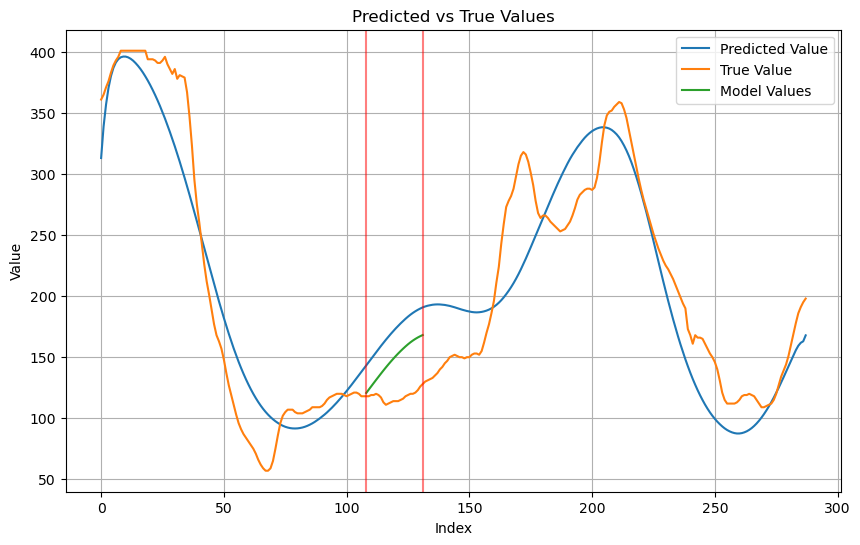

In [153]:
val_point = 12

compare_dataframe = pd.DataFrame({'True Value':preds_vs_true['Value_complete'][val_point].copy(), 'Predicted Value':preds_vs_true['Value_prediction'][val_point].copy()})

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(compare_dataframe.index, compare_dataframe['Predicted Value'], label='Predicted Value')
plt.plot(compare_dataframe.index, compare_dataframe['True Value'], label='True Value')
plt.plot(preds_vs_true['Missing_Indexes'][val_point], preds_vs_true['Offset_Predicted_Values'][val_point], label = 'Model Values')

plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).min(), color='red', alpha=0.5)
plt.axvline(x=np.array(preds_vs_true['Missing_Indexes'][val_point]).max(), color='red', alpha=0.5)

plt.title('Predicted vs True Values')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [155]:
preds_vs_true.to_csv('Seq2Seq_Bidirectional_50nodes.csv', index = False)

In [47]:
np.array(preds_vs_true['Missing_Indexes'][0]).min()

30

In [26]:
len(find_nan_indices(preds_vs_true['Value_missing'][1].copy()))

96